function to compute numpy representation from video file (thanks Yana!)

In [241]:
import numpy as np
import cv2
from utils.image import *
from utils.video import *
from utils.pipeutils import *
import os
from os.path import join,isfile,isdir
from os import listdir
from pipe import *
import random
import matplotlib.pyplot as plt
import math
import builtins
from  itertools import *

In [1]:
import numpy as np
import cv2
import os.path

# trs, let's assume width is always wider than height
def video_to_npy(infile, outfile=None, width=None, height=None, squarecrop=None, fps=None, cropat=None):
    
    # has this video already been saved before?
    if isfile(outfile):
        frames = np.load(outfile)
        if frames.shape[1]==height:
            # just return this preloaded video
            return frames
    
    print('reading fresh video from %s' % infile)
    vidcap = cv2.VideoCapture(infile)
    success, image = vidcap.read()
    
    frames = []
    count = 0
    if not success:
        raise ValueError('Could not read the video file!')
    while success:
        frames.append( image[...,::-1] )
        count += 1
        success,image = vidcap.read()
    if fps:
        span = int(vidcap.get(cv2.CAP_PROP_FPS) / fps)
        frames = frames[0::span] 
    if width or height:  
        width = width if width else int(height / frames[0].shape[0] * frames[0].shape[1])
        height = height if height else int(width / frames[0].shape[1] * frames[0].shape[0])
        frames = [ cv2.resize(frame, (width, height)) for frame in frames ]
    if squarecrop:
        tl = int((width/2)-(height/2))
        # note that x,y is the wrong way around i.e. it's
        # F x Y x X x C
        frames = [ frame[ 0:height, tl:(tl+height)] for frame in frames ]
    if cropat:
        frames = frames[0:cropat*fps]
        
    frames = np.array(frames)
    if outfile:
        np.save(outfile, frames)
    return frames

In [2]:
from random import shuffle
from pipe import *

@Pipe
def pshuffle(l):
    shuffle(l)
    return l
@Pipe
def pcycle(l):
    return cycle(l)

In [3]:
from os import listdir
from os.path import isfile, join
from itertools import *
from pipe import *

# return iterable { (label, path/video1), (label, path/video2), ... }
def GetVideos( path, label, ext='.mp4' ):
    p = listdir(path) | where( lambda p: p.endswith(ext) ) | as_list()
    return zip( repeat(label, len(p)), map( lambda p: join( path, p ), p ) )

In [4]:
import pickle
# dump a classes file so the others can see which classes I have assigned

classes = GetVideos('./videos/collisions', 1) \
    | chain_with(GetVideos('./videos/not-collisions', 0))  \
    | select( lambda i: (i[1].replace('./videos/collisions\\','').replace('./videos/not-collisions\\',''), i[0]) ) \
    | as_dict()

pickle.dump( classes, open( "class_structure.p", "wb" ) ) 

classes

{'output000-26961.mp4': 1,
 'output000-5404.mp4': 1,
 'output000.mp4': 1,
 'output001-24132.mp4': 1,
 'output001-24962.mp4': 1,
 'output001-5404.mp4': 1,
 'output001.mp4': 1,
 'output002-26961.mp4': 1,
 'output002-27378.mp4': 1,
 'output002-4994.mp4': 1,
 'output002-5404.mp4': 1,
 'output002.mp4': 1,
 'output003-24962.mp4': 1,
 'output003-26961.mp4': 1,
 'output003-27378.mp4': 1,
 'output003-5404.mp4': 1,
 'output003.mp4': 1,
 'output004-27378.mp4': 1,
 'output004-31027.mp4': 1,
 'output004-4994.mp4': 1,
 'output004-5404.mp4': 1,
 'output004.mp4': 1,
 'output005-26961.mp4': 1,
 'output005-4360.mp4': 1,
 'output005-5404.mp4': 1,
 'output005.mp4': 1,
 'output006-24132.mp4': 1,
 'output006-24962.mp4': 1,
 'output006-26961.mp4': 1,
 'output006-27378.mp4': 1,
 'output006-4994.mp4': 1,
 'output006-5404.mp4': 1,
 'output006.mp4': 1,
 'output007-24962.mp4': 1,
 'output007-26961.mp4': 1,
 'output007-31027.mp4': 1,
 'output007-4360.mp4': 1,
 'output007-5404.mp4': 1,
 'output007.mp4': 1,
 'output

In [5]:
import uuid
import pickle
import math

collisions = GetVideos('./videos/collisions', 1) | as_list() | pshuffle()
ncollisions = GetVideos('./videos/not-collisions', 0) | as_list() | pshuffle()

# what is the min number in either class?
minn = [ collisions | count, ncollisions | count ] | min

# now let's validate on 33% of that
vs = math.floor( minn * 0.33 )

In [6]:
# run this when you need to
#valset = collisions | take(vs) | chain_with( ncollisions | take(vs) ) | as_list()
# let's save this valsplit to the filesystem for use later!
#pickle.dump( valset, open( "valsplit_%s.p" % uuid.uuid4().hex, "wb" ) ) 

In [7]:
# are you running this later and want to pick up from a previous val split for consistent results?
# important; has the population of videos on the file system changed since this pickle was created?
import pickle
valset = pickle.load( open( "valsplit_1b46b8e12c244afdaf09f83241fb443a.p", "rb" ) )

In [8]:
# how many validation videos?
print(valset | count)

118


In [9]:
# now let's get a stream of train and validation videos which is label-balanced 

def videoStream():
    # handy dict to see if a file is in the validation set
    vd = valset | select( lambda t: (t[1],t[0]) ) | as_dict()
    
    
    while True:
        
        #create an infinite sequence of both, taking the same from both to ensure 
        # same average label distribution
        ic = collisions | where( lambda v: v[1] not in vd ) | as_list() | pshuffle() | take(100)
        inc = ncollisions | where( lambda v: v[1] not in vd ) | as_list() | pshuffle() | take(100)

        mixed_stream = ( ic \
            | chain_with( inc )  \
            | as_list()
            # shuffle it so we get good label mix
            | pshuffle() )
        
        for e in mixed_stream:
            yield e

In [10]:
# this is our training stream which is label balanced
stream = videoStream()

In [11]:
# check no leakage between val set and training stream!
fir = valset | first()

for i in range(400):
    s = next(stream)
    print( '%s!=%s' % ( s[1],fir[1]  ) )
    assert( s[1] is not fir[1] )

./videos/collisions\output074-31027.mp4!=./videos/collisions\output003.mp4
./videos/collisions\output004-5404.mp4!=./videos/collisions\output003.mp4
./videos/collisions\output067-24962.mp4!=./videos/collisions\output003.mp4
./videos/not-collisions\output122-14767.mp4!=./videos/collisions\output003.mp4
./videos/collisions\output007.mp4!=./videos/collisions\output003.mp4
./videos/collisions\output106.mp4!=./videos/collisions\output003.mp4
./videos/not-collisions\output097.mp4!=./videos/collisions\output003.mp4
./videos/not-collisions\output240-14767.mp4!=./videos/collisions\output003.mp4
./videos/not-collisions\output345-14767.mp4!=./videos/collisions\output003.mp4
./videos/not-collisions\output075-14767.mp4!=./videos/collisions\output003.mp4
./videos/not-collisions\output125-14767.mp4!=./videos/collisions\output003.mp4
./videos/collisions\output062.mp4!=./videos/collisions\output003.mp4
./videos/collisions\output003-26961.mp4!=./videos/collisions\output003.mp4
./videos/not-collisions\ou

for every video in the collisions/non collisions folder, compute the numpy representation 

In [12]:
# adorn the video to the tuple iterator, return cloned+appended tuple
@Pipe
def adornVideo(iterator, framerate=25, video_size=64, max_length=5):
    return iterator \
        | select( lambda f: f + ( 
            video_to_npy( f[1], 
                         #note weird thing here, width doesn't work they appear to be inverted
                         height=video_size, 
                         squarecrop=True, 
                         fps=framerate,
                         cropat=max_length,
                         # save a npy replacement
                         outfile=f[1].replace('.mp4','_%d.npy' % (video_size) )
            ), ) )


ok, so at this point we now have a numpy array for every single video file! the numpy arrays are fixed on some video size, length and frame rate i.e. 200^2, 5 seconds and 25fps.  

For every single video file, we compute a random augmentation consistently across all of the frames

In [13]:
import random

from keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=5,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True)

image_datagen = ImageDataGenerator(**data_gen_args)

@Pipe
def augmentation( 
    flow,
    colpath='./collisions',
    noncolpath='./not-collisions',
    augment=True, 
    diff=False,
    normalize=True):
   
    for video in flow:
        # for every frame in this video generate the same transformation
        # and yield it all back in sequence order
        trans = image_datagen.get_random_transform(video[2].shape)
        augmentedVideo = np.zeros( video[2].shape )
        for i in range(video[2].shape[0]):
            if augment:
                augmentedVideo[i] = image_datagen.apply_transform(video[2][i], trans)
            else:
                augmentedVideo[i] = video[2][i]
            
            # now is a good time to transform the video onto 0-1
            # we need to do this to get convergence when we train i.e. homogenise features
            if normalize:
                augmentedVideo[i] = augmentedVideo[i] / 255
            
            # take xth order differences of frames to convey pixel-wise temporal changes
            if diff is not None:
                augmentedVideo[i, 0:augmentedVideo[i].shape[0]-diff] = np.diff(augmentedVideo[i], axis=0, n=diff)
            
        yield video[:-1] + (augmentedVideo,)


Using TensorFlow backend.


let's visualize the augmented results for this video

In [14]:
import matplotlib.pyplot as plt

def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.xticks([]), plt.yticks([])
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.tight_layout()
    plt.show()
    display()

(36, 64, 64, 3)
(110, 64, 64, 3)
(125, 64, 64, 3)


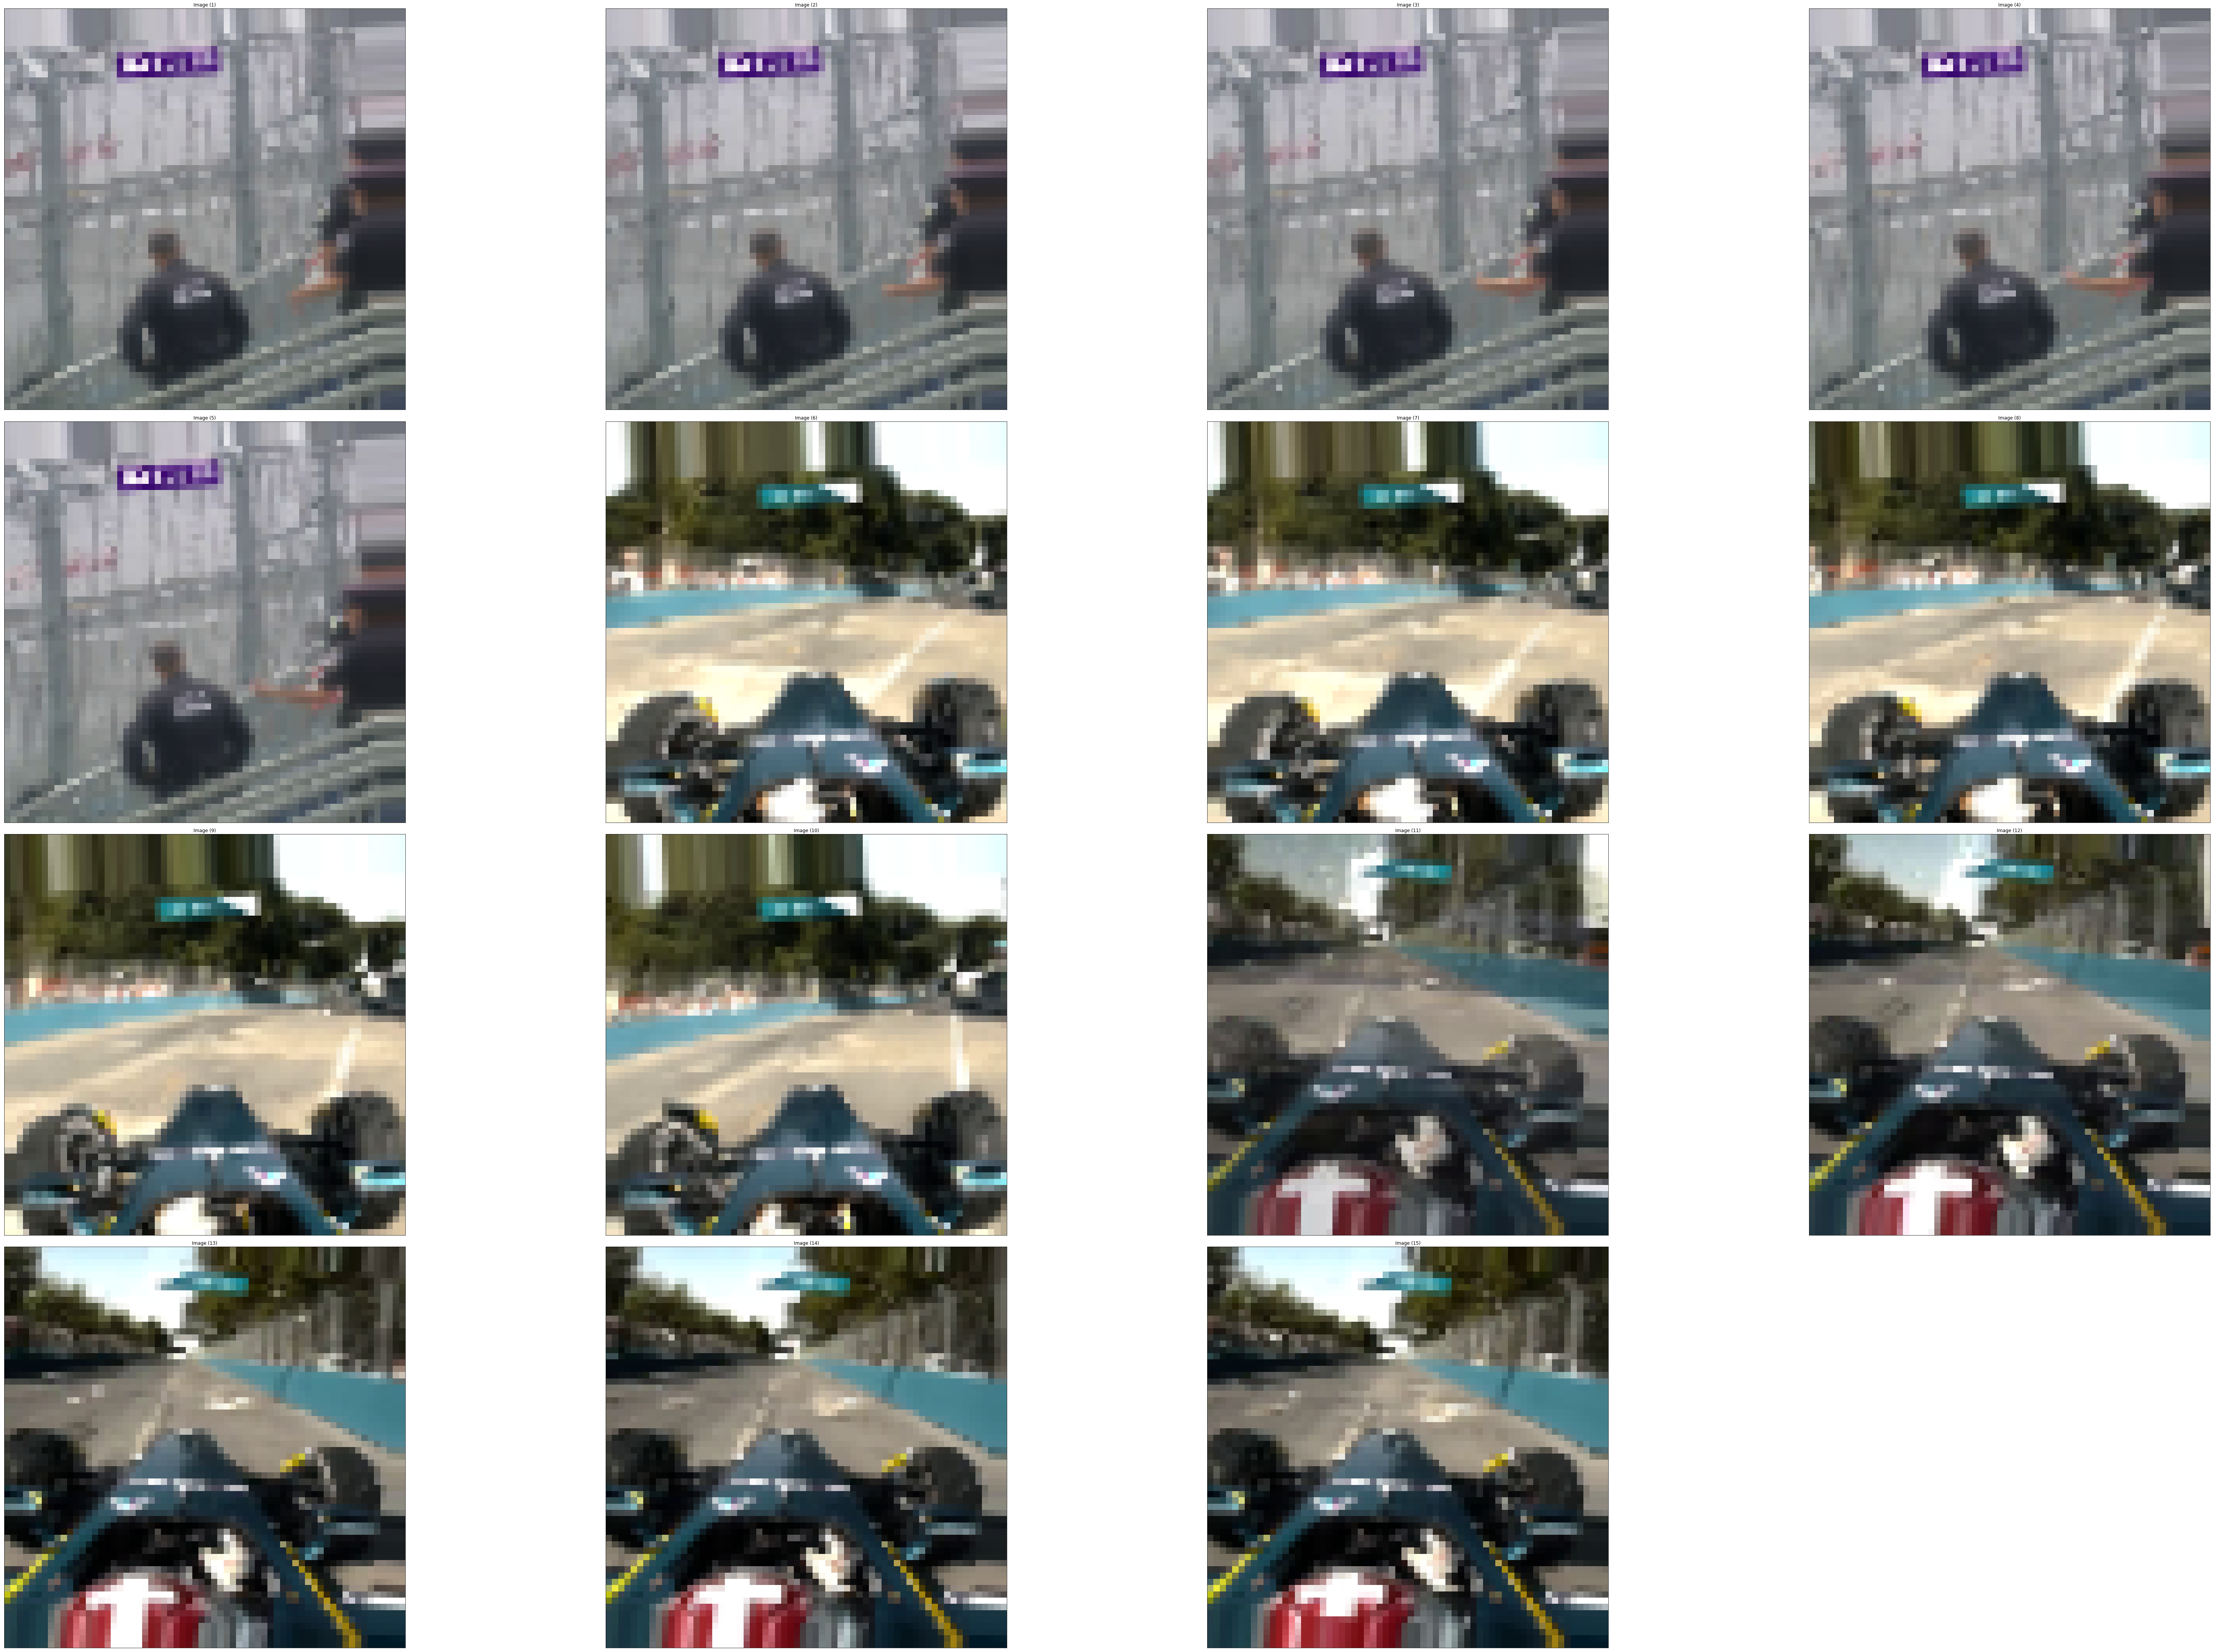

(125, 64, 64, 3)
(60, 64, 64, 3)
(124, 64, 64, 3)


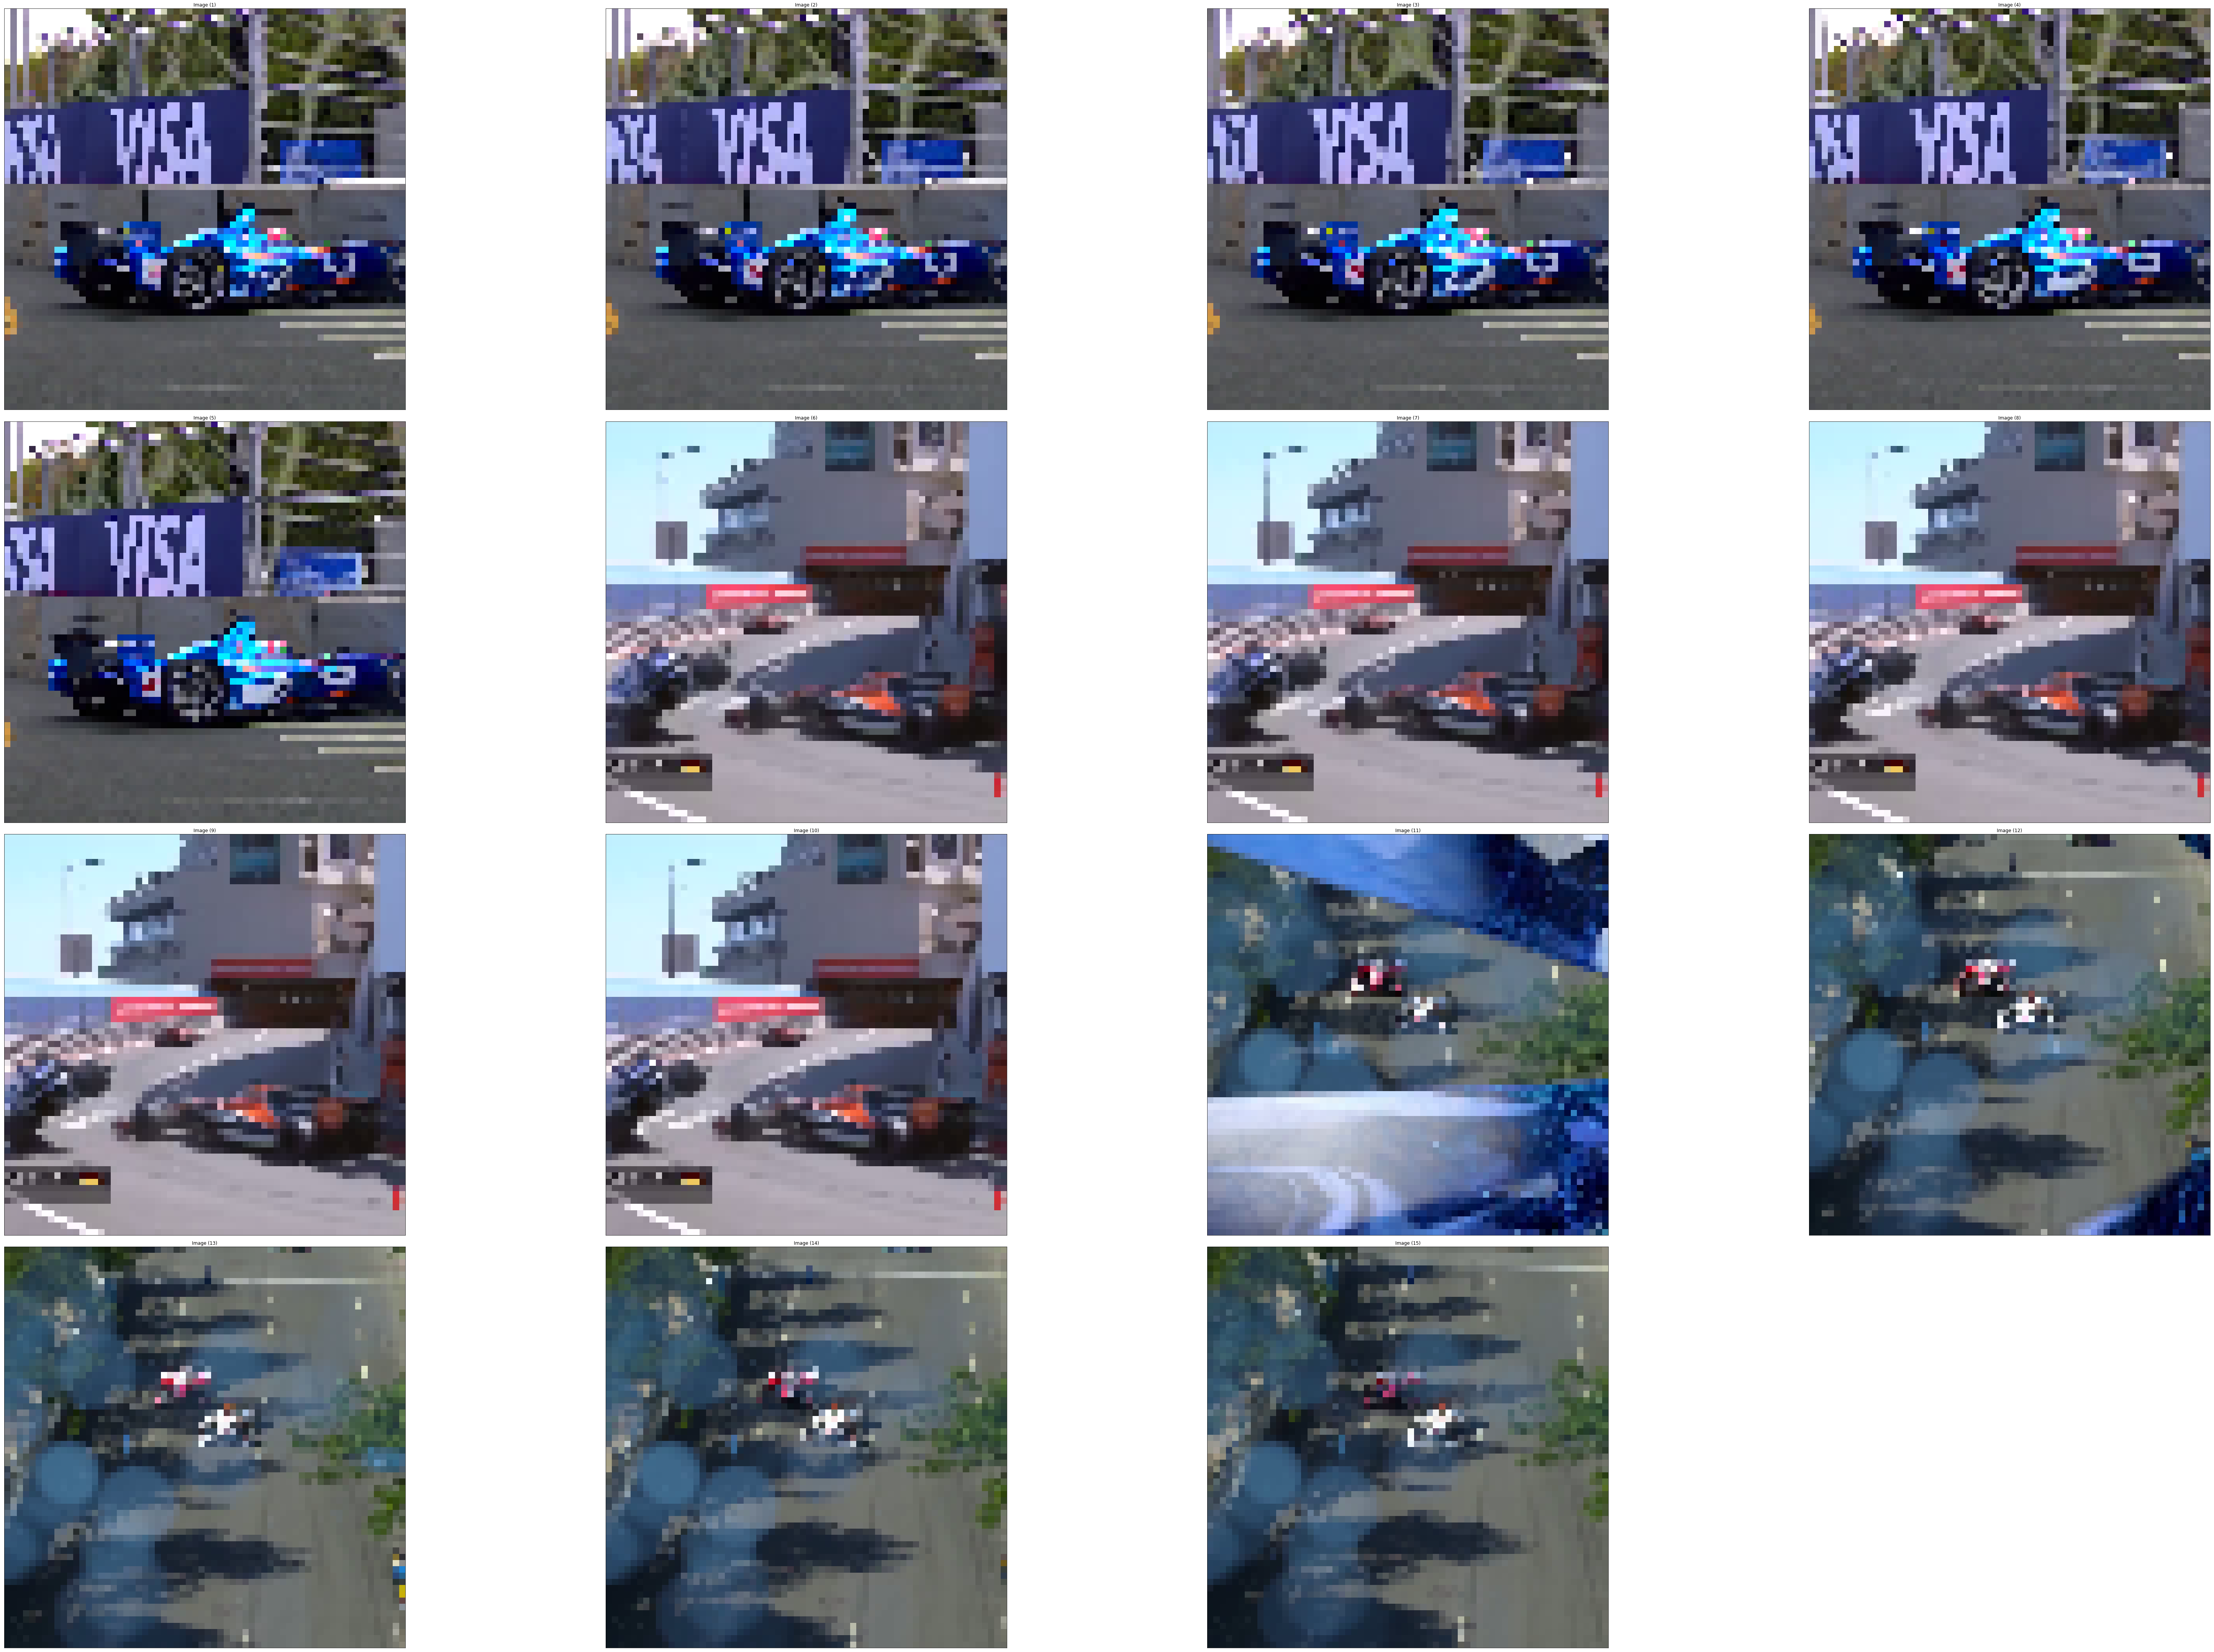

In [15]:
train_withvideo_aug = stream |  adornVideo() | augmentation(diff=None, augment=True)
val_withvideo = valset | adornVideo()

def getTestImages(flow, howmany=5):
    augmentedVideo = next(flow)
    print(augmentedVideo[2].shape)
    return range(augmentedVideo[2].shape[0]) \
        | select( lambda i: augmentedVideo[2][i] ) \
        | take(howmany) 

# show some augmented train images
images = getTestImages(train_withvideo_aug)

for x in range(2):
    images = images | chain_with( getTestImages(train_withvideo_aug) )

show_images( images | as_list, cols=4 )

# and do the same for some validation images
images = getTestImages(val_withvideo)
for x in range(2):
    images = images | chain_with( getTestImages(val_withvideo) )

show_images( images | as_list, cols=4 )

ok this is looking pretty good, next thing is to zeropad so that the number of frames is always the same i.e. max seconds * framerate

In [27]:
@Pipe
def zeroPadVideos(videoStream, video_size=64, max_length=5, framerate=25):
    for video in videoStream:
        zeroPadded = np.zeros( ( max_length * framerate, video_size, video_size, 3 ) )
        zeroPadded[ 0:video[2].shape[0], :, : ,: ] = video[2]
        yield video[:-1] + (zeroPadded,)

# we will need to do the same thing to the validation stream as what happened to the train stream!
@Pipe
def normalizeVideos(videoStream):
    for video in videoStream:
        
        yield ( video[0], video[1], video[2]/255  )

In [48]:
@Pipe
def adornDenseFlow(videoStream):
    for video in videoStream:
        
        flows = np.load( video[1].replace('.mp4','.flows.npy') )
        
        yield video + (flows,)

OK the next problem is we have a nice generator for videos, but we are doing a 4d CNN with videos and need a batch dimension, so let's write another generator which will batch X videos at a time

```
next( zeroPadVideos( flow ) )[3].shape
```
== (125, 200, 200, 3)


In [101]:
@Pipe
def getBatchVideosFlow(flow, batchsize=10, video_size=64, max_length=5, framerate=25):
    while(True):
        batch = np.zeros( (batchsize, max_length * framerate, video_size, video_size, 3 ) )
        labels = np.zeros( (batchsize,1))
        for i in range(batchsize):
            video = next( flow )
            batch[i] = video[2]
            labels[i] = video[0]
        yield ( batch, labels )
     
    
@Pipe
def zeroPadVideos(videoStream, video_size=64, max_length=5, framerate=25):
    for video in videoStream:
        zeroPadded = np.zeros( ( max_length * framerate, video_size, video_size, 3 ) )
        zeroPadded[ 0:video[2].shape[0], :, : ,: ] = video[2]
        yield video[:-1] + (zeroPadded,)
    


In [245]:
# dense flow stuff

@Pipe
def getBatchVideosDenseFlow(flow, batchsize=10, video_size=64, max_length=5, framerate=25):
    while(True):
        batch = np.zeros( (batchsize, 125, 100, 2 ) )
        labels = np.zeros( (batchsize,1))
        for i in range(batchsize):
            video = next( flow )
            batch[i] = video[2]
            labels[i] = video[0]
        yield ( batch, labels )

@Pipe
def zeroPadDenseFlowVideos(videoStream, max_length=5, framerate=25):
    
    for video in videoStream:
        zeroPadded = np.zeros( ( max_length * framerate, 100, 2 ) )
        zeroPadded[ 0:video[2].shape[0], :, : ] = video[2]
        yield video[:-1] + (zeroPadded,)
    
    
maxs = stream | take(200) | select(lambda x : x[1].replace('.mp4','.flows.npy')) \
           | select(lambda x : np.load(x)) \
           | select(lambda x : x.max(axis=(0,1))) \
           | as_npy

mins,maxs,avgs = maxs.min(axis=0),maxs.max(axis=0),np.average(maxs,axis=0)

print(mins,maxs,avgs)
ang_diap = (mins[0],avgs[0])
mag_diap = (mins[1],maxs[1])

@Pipe
def normalizeDenseFlow(flow):
    for x in flow:
        x2 = x[2]
        x2[:,:,0] = (x2[:,:,0]-ang_diap[0]) / (ang_diap[1]-ang_diap[0])
        x2[:,:,1] = (x2[:,:,1]-mag_diap[0]) / (mag_diap[0]-mag_diap[1])
        yield x[0],x[1],x2
    

[1.20000000e+04 1.05143938e+01] [1.48755000e+05 1.19822601e+01] [7.78331650e+04 1.17639844e+01]


We now have a generator giving us batches of training examples and respective labels, we can feed this into keras fit_generator!

How big is a batch i.e. will it fit in memory?

now let's try and train keras on it

In [246]:
video_size = 64
framerate = 25
max_length = 5
batchsize = 10

print('training with videosize: %s framerate: %d' % (video_size, framerate))

# make a fresh stream for clarity
train_stream = ( videoStream() 
    | where( lambda f: isfile(f[1].replace('.mp4','.flows.npy')) )
    # actually load the respective video into memory
   # | adornVideo(framerate=framerate, video_size=video_size, max_length=max_length) 
    # for all frames in this video, randomly augment them in the same way
    #| zeroPadVideos(video_size)
    | adornDenseFlow()
    | normalizeDenseFlow()
    | zeroPadDenseFlowVideos() 
    #| augmentation(diff=False, augment=True, normalize=True) 
    #| normalizeVideos()
    # batch into X videos to match Keras modality
    | getBatchVideosDenseFlow( batchsize, video_size ) )

# recall valset is our precomputed list of validation videos (50/50 label split)
val_stream = ( valset 
    | where( lambda f: isfile(f[1].replace('.mp4','.flows.npy')) )
    #| adornVideo(framerate=framerate, video_size=video_size, max_length=max_length) 
    | adornDenseFlow()
    | normalizeDenseFlow()
    | zeroPadDenseFlowVideos()
    #| normalizeVideos()
    #| zeroPadVideos(video_size) 
    # we need this to be an infinite sequence for Keras but fear not
    # all validation samples will be returned before a cycle
    | pcycle() 
    | getBatchVideosDenseFlow( batchsize, video_size ) )


training with videosize: 64 framerate: 25


In [252]:
from keras import layers
from keras import models
from keras import optimizers
from keras.regularizers import l2

model = models.Sequential()
model.add(layers.AveragePooling2D((2, 2),input_shape=(max_length * framerate, 100, 2)))
model.add(layers.Conv2D(8, (3, 3), data_format='channels_last',activation='relu',kernel_initializer='glorot_uniform',kernel_regularizer=l2(0.01)))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3) ,activation='relu',kernel_initializer='glorot_uniform',kernel_regularizer=l2(0.01)))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100,activation='relu',kernel_initializer='glorot_uniform',kernel_regularizer=l2(0.01)))
model.add(layers.Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',kernel_regularizer=l2(0.01)))
model.compile(loss='binary_crossentropy',
              #optimizer=optimizers.Nadam(lr=0.005),
              optimizer=optimizers.adam(),
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_3 (Average (None, 62, 50, 2)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 48, 8)         152       
_________________________________________________________________
average_pooling2d_4 (Average (None, 30, 24, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 22, 16)        1168      
_________________________________________________________________
average_pooling2d_5 (Average (None, 14, 11, 16)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2464)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2464)              0         
__________

In [253]:
from keras import optimizers
from keras import callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Nadam(lr=0.002),
              metrics=['acc'])

filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoint =  callbacks.ModelCheckpoint(filepath, 
                          monitor='val_loss', 
                          verbose=0, 
                          save_best_only=False, 
                          save_weights_only=False, 
                          mode='auto', 
                          period=1)

history = model.fit_generator(
      train_stream,
      steps_per_epoch=100, 
      validation_data=val_stream, 
      # has to be false on windows..
      use_multiprocessing=False, 
      validation_steps = 50,
      epochs=50,
      callbacks = [checkpoint])

Epoch 1/50
100/100 [==============================] - 5s 50ms/step - loss: 1.3143 - acc: 0.6000 - val_loss: 0.9415 - val_acc: 0.5540
Epoch 2/50
100/100 [==============================] - 4s 36ms/step - loss: 0.8348 - acc: 0.6770 - val_loss: 0.7738 - val_acc: 0.5960
Epoch 3/50
100/100 [==============================] - 4s 36ms/step - loss: 0.7166 - acc: 0.7080 - val_loss: 0.7490 - val_acc: 0.6260
Epoch 4/50
100/100 [==============================] - 4s 36ms/step - loss: 0.6938 - acc: 0.7140 - val_loss: 0.8190 - val_acc: 0.5480
Epoch 5/50
100/100 [==============================] - 4s 36ms/step - loss: 0.6553 - acc: 0.7400 - val_loss: 0.7909 - val_acc: 0.5960
Epoch 6/50
100/100 [==============================] - 4s 36ms/step - loss: 0.6420 - acc: 0.7400 - val_loss: 0.7307 - val_acc: 0.6240
Epoch 7/50
100/100 [==============================] - 4s 36ms/step - loss: 0.6463 - acc: 0.7320 - val_loss: 0.8504 - val_acc: 0.5620
Epoch 8/50
100/100 [==============================] - 4s 36ms/step - 

Now we plot to see the convergence behaviour and overfitting

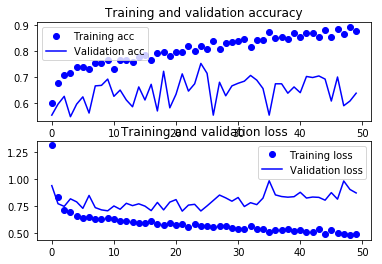

In [254]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


f, (ax1,ax2) = plt.subplots(2,1)

epochs = range(len(acc))

ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.legend()


ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()

plt.show()
